In [1]:
# Begin by importing all required libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import datasets
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


# Prepare Data for Training

Before any preprocessing, it's important to understand the structure, type, and quality of the raw data. This involves looking at the first few rows, which can give insights into the various features available and their data types.

Decision tree algorithms can't handle missing values directly. The presence of missing data can lead to errors during the fit process or can significantly bias the model. Calculating the percentage of missing data helps in making informed decisions about whether to impute missing values, drop the rows/columns, or use techniques like introducing a 'missing' category for categorical data.

Replacing missing values with a central tendency measure (median for numerical data and mode for categorical data) is a common practice to retain valuable data points. It's preferable to dropping rows or columns entirely, especially in datasets where data is scarce. Dropping unnecessary columns like 'PassengerId', 'Name', and 'VIP' is done to remove features that are unlikely to be useful for the model. These might include identifiers that are unique to each instance or features that don't contribute to the predictive power of the model.

Transforming 'Cabin' into 'Deck' and 'Side' is an example of feature engineering, where new features are created from existing ones. This can help the decision tree capture more nuanced patterns in the data that might not be apparent from the original features.Decision trees require all data to be numerical. Converting boolean values to integers (e.g., 'CryoSleep') and applying label encoding to categorical variables transforms them into a format that the algorithm can work with. Label encoding assigns a unique integer to each category of a feature, making the data suitable for modeling without introducing an arbitrary ordinal relationship.

In [2]:
# Read data
train_df = pd.read_csv('csv_files/train.csv')

# Preview data
print('Raw data format:')
display(train_df.head())

# Determining the amount of missing data per column
missing_data = train_df.isna().sum()

# Calculating the percentage of missing data per column
missing_percentage = (missing_data / len(train_df)) * 100

missing_info = pd.DataFrame({
    "Missing Values": missing_data,
    "Percentage": missing_percentage
})

missing_info.sort_values(by="Missing Values", ascending=False)

# Imputers
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

# List of numerical and categorical columns that need imputation
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Imputation
train_df[numerical_cols] = median_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = mode_imputer.fit_transform(train_df[categorical_cols])


# Assuming train_df is predefined
decision_tree_df = train_df.copy()  # Use copy to avoid SettingWithCopyWarning

# Drop unnecessary columns
decision_tree_df.drop(columns=['PassengerId', 'Name', 'VIP'], inplace=True)

decision_tree_df.dropna(subset=['Cabin'], inplace=True)

# Split 'Cabin' into 'Deck' and 'Side'
decision_tree_df['Deck'] = decision_tree_df['Cabin'].str.split('/').str[0]
decision_tree_df['Side'] = decision_tree_df['Cabin'].str.split('/').str[2]

decision_tree_df.drop(columns=['Cabin'], inplace=True) 

# Convert 'CryoSleep' boolean to int
decision_tree_df['CryoSleep'] = decision_tree_df['CryoSleep'].astype(int)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical variables
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    decision_tree_df[col] = label_encoder.fit_transform(decision_tree_df[col])

# After edits for decision trees
print('DataFrame used for trees:')
decision_tree_df.head()


Raw data format:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


DataFrame used for trees:


,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,1,0,2,39.0,0.0,0.0,0.0,0.0,0.0,False,1,0
1,0,0,2,24.0,109.0,9.0,25.0,549.0,44.0,True,5,1
2,1,0,2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,1
3,1,0,2,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,1
4,0,0,2,16.0,303.0,70.0,151.0,565.0,2.0,True,5,1


# 1. Decision Trees

### Decision Trees in Machine Learning

A Decision Tree is a non-parametric supervised learning method used for classification and regression tasks. It creates a model that predicts the target variable by learning decision rules from features.

#### Structure of a Decision Tree

- **Nodes**: These define the structure of a decision tree.
  - **Root Node**: Represents the entire dataset and is the starting point of the tree.
  - **Decision Nodes**: Nodes that split into more nodes based on a decision rule.
  - **Leaf Nodes/Terminal Nodes**: Nodes that provide the prediction and do not split further.

#### Learning Process

1. **Select the Best Feature**: The algorithm selects the feature that results in the most beneficial split according to a certain criterion (e.g., Gini impurity, entropy, or variance reduction).

2. **Split the Data**: The dataset is divided into subsets based on the selected feature.

3. **Recurse on Each Sub-Dataset**: The splitting process is applied recursively to each subset.

4. **Stopping Criteria**: The recursion stops if any of the following conditions are met:
   - All observations in a node have the same value of the target variable.
   - No further features are available to split on.
   - A predefined tree depth is reached.
   - A node has too few samples to split further.

5. **Prediction**: To make a prediction:
   - **Classification**: Traverse from the root to a leaf node based on the input features, and use the class label of the leaf as the prediction.
   - **Regression**: Similarly, traverse the tree, but the prediction is a continuous value, typically the average of target values in the leaf node.

#### Important Features of Decision Trees

- **Interpretability**: Easy to understand and interpret visually.
- **Non-Linear Data Handling**: Can process both numerical and categorical data and model complex relationships.
- **Feature Importance**: They prioritize the most informative features first.
- **Overfitting**: Prone to overfitting, which can be mitigated by pruning, setting maximum depth, or minimum samples per leaf.


# Types of Decision Trees and Tree-Based Models

Decision trees and tree-based models are powerful tools in machine learning for handling both regression and classification tasks. They involve segmenting the predictor space into a number of simple regions to make predictions. Here, we discuss the traditional Decision Tree and its advanced ensemble variants like Gradient Boost, Extreme Gradient Boost (XGBoost), LightGBM, and CatBoost.

## 1. Decision Tree

A Decision Tree is a non-linear predictive model that recursively splits data into branches, making it easier to interpret and visualize. It consists of nodes that form a root, internal nodes, and leaf nodes. Each internal node denotes a test on an attribute, each branch represents the outcome of the test, and each leaf node holds a class label or continuous value.

### Characteristics:
- Easy to understand and interpret.
- Can handle both numerical and categorical data.
- Prone to overfitting, especially with complex datasets.

## 2. Gradient Boost

Gradient Boosting is an ensemble technique that builds trees in a sequential manner. Each tree is built to correct the errors made by the previous trees. Unlike the traditional decision tree, it combines the outcome of multiple weak models to produce a strong predictive model.

### Characteristics:
- Minimizes a loss function in a gradient descent manner.
- Each tree tries to correct the mistakes of the previous ones.
- Can be prone to overfitting without proper regularization and tree constraints.

## 3. Extreme Gradient Boost (XGBoost)

XGBoost stands for Extreme Gradient Boosting and is an optimized distributed gradient boosting library. It enhances the speed and performance of gradient boost models. XGBoost applies regularization terms to the cost function, which helps in controlling over-fitting.

### Characteristics:
- Highly efficient, scalable, and portable.
- Implements advanced features like handling missing values internally, tree pruning, and regularization to prevent overfitting.
- Widely used in machine learning competitions due to its performance and speed.

## 4. LightGBM

LightGBM, or Light Gradient Boosting Machine, is another gradient boosting framework designed for speed and efficiency. It uses a novel technique of Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB) to handle large datasets effectively.

### Characteristics:
- Faster training speed and higher efficiency.
- Lower memory usage.
- Can handle large-scale data and is capable of performing equally well with a fraction of computing resources compared to other models.

## 5. CatBoost

CatBoost stands for Categorical Boosting. It is an algorithm that specializes in handling categorical variables very efficiently. CatBoost can automatically deal with categorical variables and does not require extensive data preprocessing like one-hot encoding.

### Characteristics:
- Provides excellent handling of categorical features.
- Reduces the need for extensive hyper-parameter tuning.
- Offers robust out-of-the-box performance with minimal data preprocessing.

Each of these models has its unique strengths and is suited for different types of data and problems. The choice between them depends on the specific requirements of the task, such as the nature of the input data, the size of the dataset, and the computational efficiency required.


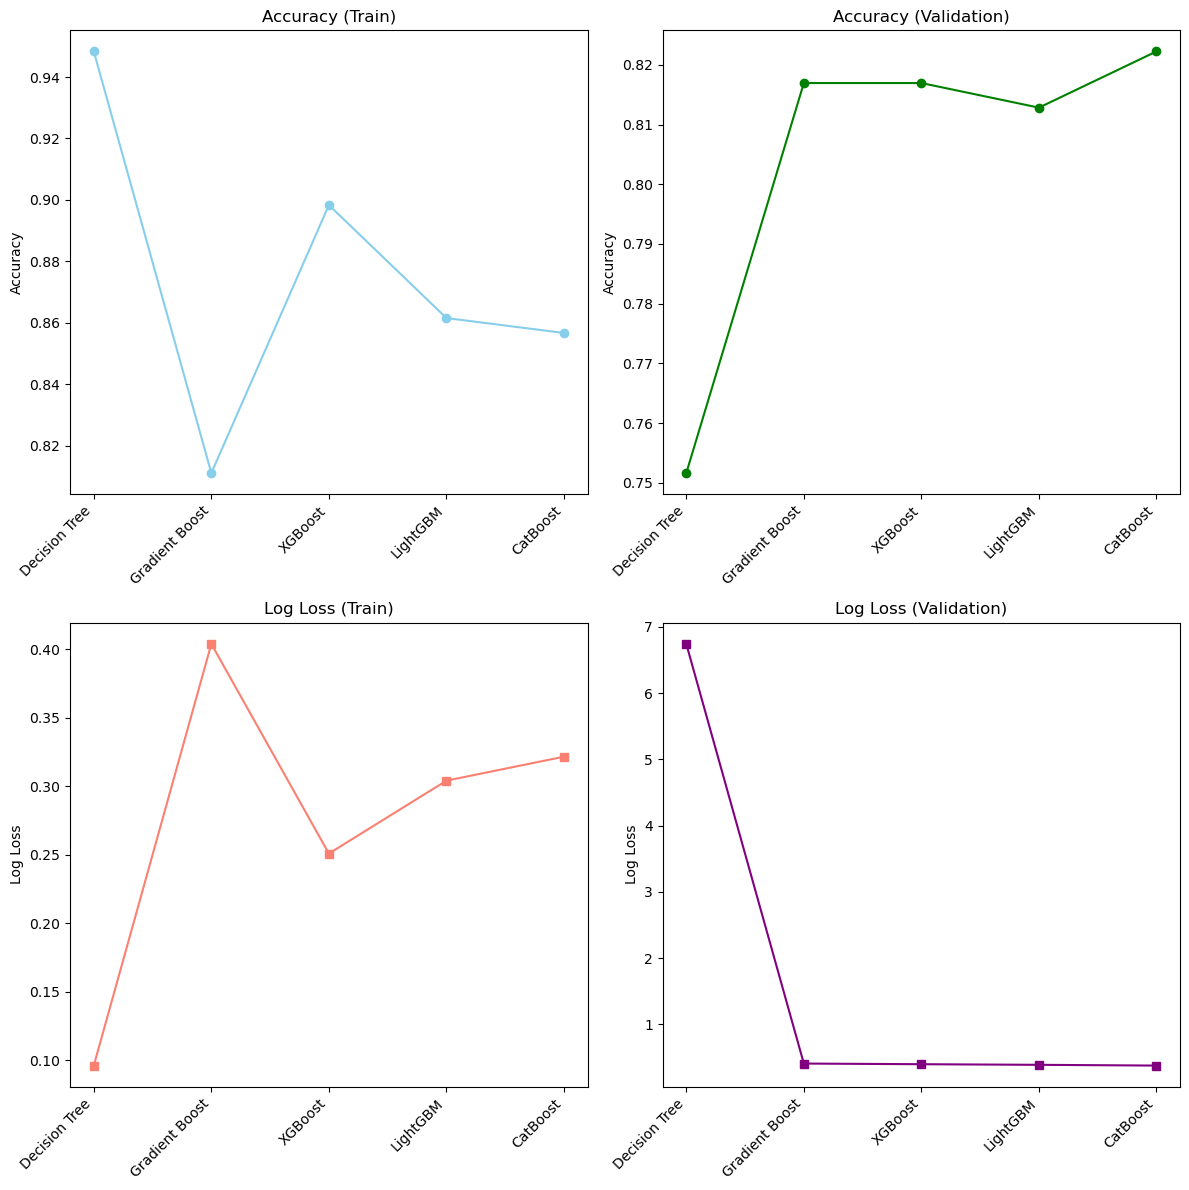

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Your decision_tree_df definition should go here

X = decision_tree_df.drop(['Transported'], axis=1)  # Features
y = decision_tree_df['Transported']  # Target variable

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boost" : GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(verbose=-1),  # Set verbose to -1 to suppress output
    "CatBoost": CatBoostClassifier(silent=True)
}

# Store metrics
metrics = {
    "Model": [],
    "Accuracy (Train)": [],
    "Accuracy (Validation)": [],
    "Log Loss (Train)": [],
    "Log Loss (Validation)": []
}

# Train models and record performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Convert predictions to boolean if they are returned as strings
    if isinstance(y_train_pred[0], str):
        y_train_pred = y_train_pred == 'True'
    if isinstance(y_val_pred[0], str):
        y_val_pred = y_val_pred == 'True'

    y_train_proba = model.predict_proba(X_train)
    y_val_proba = model.predict_proba(X_val)

    metrics["Model"].append(name)
    metrics["Accuracy (Train)"].append(accuracy_score(y_train, y_train_pred))
    metrics["Accuracy (Validation)"].append(accuracy_score(y_val, y_val_pred))
    metrics["Log Loss (Train)"].append(log_loss(y_train, y_train_proba))
    metrics["Log Loss (Validation)"].append(log_loss(y_val, y_val_proba))


# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Convert Model names to numerical indices for line plot
model_indices = range(len(metrics["Model"]))

# Line plot for Accuracy (Train)
axs[0, 0].plot(model_indices, metrics["Accuracy (Train)"], marker='o', linestyle='-', color='skyblue')
axs[0, 0].set_title('Accuracy (Train)')
axs[0, 0].set_xticks(model_indices)
axs[0, 0].set_xticklabels(metrics["Model"], rotation=45, ha='right')
axs[0, 0].set_ylabel('Accuracy')

# Line plot for Accuracy (Validation)
axs[0, 1].plot(model_indices, metrics["Accuracy (Validation)"], marker='o', linestyle='-', color='green')
axs[0, 1].set_title('Accuracy (Validation)')
axs[0, 1].set_xticks(model_indices)
axs[0, 1].set_xticklabels(metrics["Model"], rotation=45, ha='right')
axs[0, 1].set_ylabel('Accuracy')

# Line plot for Log Loss (Train)
axs[1, 0].plot(model_indices, metrics["Log Loss (Train)"], marker='s', linestyle='-', color='salmon')
axs[1, 0].set_title('Log Loss (Train)')
axs[1, 0].set_xticks(model_indices)
axs[1, 0].set_xticklabels(metrics["Model"], rotation=45, ha='right')
axs[1, 0].set_ylabel('Log Loss')

# Line plot for Log Loss (Validation)
axs[1, 1].plot(model_indices, metrics["Log Loss (Validation)"], marker='s', linestyle='-', color='purple')
axs[1, 1].set_title('Log Loss (Validation)')
axs[1, 1].set_xticks(model_indices)
axs[1, 1].set_xticklabels(metrics["Model"], rotation=45, ha='right')
axs[1, 1].set_ylabel('Log Loss')

plt.tight_layout()
plt.show()



From the plot, here are some insights that can be drawn:

- **Accuracy (Train):** The Decision Tree, has a particularly high accuracy on the training set compared to the others, which suggests that it has learned the training data well. However, high training accuracy could also be indicative of overfitting, especially if it is not matched by high validation accuracy.

- **Accuracy (Validation):** The Decision Tree, having the highest training accuracy, does not have the highest validation accuracy, which could further suggest overfitting. Since CatBoost performs best on the validation data, it is likely to be the most generalizable of he five models.

- **Log Loss (Train):** There is a significant increase in the log loss for the Decision Tree. High log loss indicates poor performance of the model as it implies a larger divergence between the predicted probabilities and the actual labels.

- **Log Loss (Validation):** Similar to the training log loss, the Decision Tree exhibits a high log loss on the validation set, suggesting it is not predicting the probabilities as well as the other models. The model with the lowest log loss on the validation set is likely to be the best probabilistic predictor among the four models.


# Feature Engineering 

Feature engineering is a critical step in the machine learning pipeline, as it involves creating more predictive features or improving existing ones to increase the performance of a model. In this context, techniques like cross-validation and Recursive Feature Elimination (RFE) are especially useful.

## Cross-validation

Cross-validation is a model validation technique that assesses how the results of a statistical analysis will generalize to an independent data set. It is primarily used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

The process of cross-validation involves partitioning a sample of data into complementary subsets, performing the analysis on one subset (the training set), and validating the analysis on the other subset (the validation set). To reduce variability, multiple rounds of cross-validation are performed using different partitions, and the validation results are averaged over the rounds.

### Example of Cross-validation in Feature Engineering

In feature engineering, cross-validation can be used to assess the predictive power of each feature and to detect overfitting. By removing features that do not improve model performance in cross-validation, one can reduce model complexity and improve generalizability.

## Recursive Feature Elimination (RFE)

Recursive Feature Elimination (RFE) is a feature selection method that fits a model and removes the weakest feature(s) until the specified number of features is reached. Features are ranked by the model's `coef_` or `feature_importances_` attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

### Example of RFE in Feature Engineering

RFE can be combined with cross-validation (often referred to as RFECV) to select the optimal number of features and to avoid overfitting. For example, in a classification problem, RFE could be applied with a logistic regression model to identify the subset of features that contribute most to predicting the target variable.


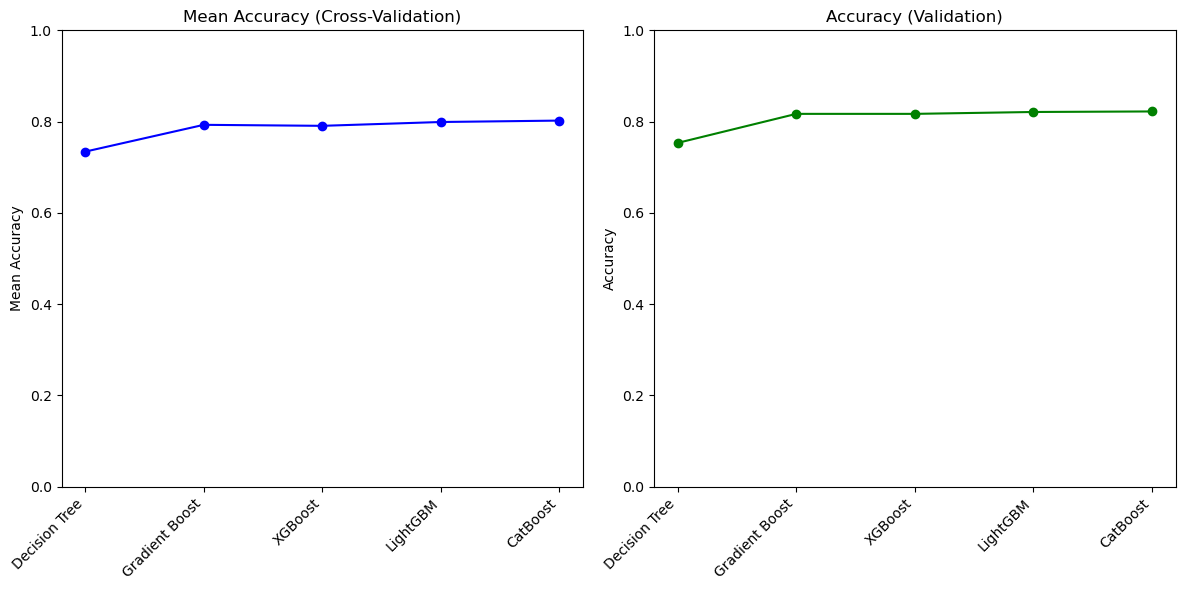

,Model,Mean Accuracy (Cross-Validation),Accuracy (Validation),Number of Features,Important Features
0,Decision Tree,0.734216,0.753384,8,"[CryoSleep, Age, RoomService, FoodCourt, Shopp..."
1,Gradient Boost,0.792936,0.816951,11,"[HomePlanet, CryoSleep, Destination, Age, Room..."
2,XGBoost,0.790728,0.816951,11,"[HomePlanet, CryoSleep, Destination, Age, Room..."
3,LightGBM,0.799117,0.821071,10,"[HomePlanet, Destination, Age, RoomService, Fo..."
4,CatBoost,0.802208,0.822248,11,"[HomePlanet, CryoSleep, Destination, Age, Room..."


In [22]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV

y_train = y_train.astype(int)
y_val = y_val.astype(int)

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5)

# Store metrics
metrics = {
    "Model": [],
    "Mean Accuracy (Cross-Validation)": [],
    "Accuracy (Validation)": [],
    "Number of Features": [],
    "Important Features": []
}

## Train models, apply feature selection, and record performance
for name, model in models.items():
    # RFECV for feature selection combined with cross-validation
    selector = RFECV(estimator=model, step=1, cv=cv_strategy, scoring='accuracy')
    selector = selector.fit(X_train, y_train)
    
    # Selected features
    X_train_rfe = selector.transform(X_train)
    X_val_rfe = selector.transform(X_val)

    # Cross-validation for model evaluation on training data
    cv_scores = cross_val_score(model, X_train_rfe, y_train, cv=cv_strategy, scoring='accuracy')

    # Fit the model with selected features for validation set evaluation
    model.fit(X_train_rfe, y_train)
    y_val_pred = model.predict(X_val_rfe)
    
    # Convert predictions to int for accuracy calculation
    y_val_pred = y_val_pred.astype(int)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Store the average cross-validation score and the validation set score
    metrics["Model"].append(name)
    metrics["Mean Accuracy (Cross-Validation)"].append(cv_scores.mean())
    metrics["Accuracy (Validation)"].append(val_accuracy)
    metrics["Number of Features"].append(selector.n_features_)
    metrics["Important Features"].append(X_train.columns[selector.support_].tolist())

# Create a DataFrame for displaying the results in a table
metrics_df = pd.DataFrame(metrics)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Line plot for Mean Accuracy (Cross-Validation)
axs[0].plot(metrics["Model"], metrics["Mean Accuracy (Cross-Validation)"], marker='o', linestyle='-', color='blue')
axs[0].set_title('Mean Accuracy (Cross-Validation)')
axs[0].set_xticks(range(len(metrics["Model"])))
axs[0].set_xticklabels(metrics["Model"], rotation=45, ha='right')
axs[0].set_ylabel('Mean Accuracy')
axs[0].set_ylim([0, 1])  # Assuming accuracy is between 0 and 1

# Line plot for Accuracy (Validation)
axs[1].plot(metrics["Model"], metrics["Accuracy (Validation)"], marker='o', linestyle='-', color='green')
axs[1].set_title('Accuracy (Validation)')
axs[1].set_xticks(range(len(metrics["Model"])))
axs[1].set_xticklabels(metrics["Model"], rotation=45, ha='right')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 1])  # Assuming accuracy is between 0 and 1

plt.tight_layout()
plt.show()

# Find common features selected by all models
common_features = set(metrics_df['Important Features'][0])
for features in metrics_df['Important Features'][1:]:
    common_features.intersection_update(features)

print("Common Important Features across all models:", common_features)


display(metrics_df)

In [23]:
from itertools import combinations
from sklearn.metrics import accuracy_score

# Placeholder for the top three results per model
top_results = {
    model_name: [] for model_name in models.keys()  # Initialize with model names
}

# Iterate over each model
for name, model in models.items():
    # Generate combinations of features, for simplicity let's say up to 3 features
    for combo_length in range(1, 4):  # Adjust range as needed
        for feature_combo in combinations(X_train.columns, combo_length):
            # Select only the features in this combination
            X_train_subset = X_train[list(feature_combo)]
            X_val_subset = X_val[list(feature_combo)]
            
            # Cross-validate the model on this feature subset
            cv_scores = cross_val_score(model, X_train_subset, y_train, cv=cv_strategy, scoring='accuracy')
            
            # Fit the model and evaluate on the validation set
            model.fit(X_train_subset, y_train)
            y_val_pred = model.predict(X_val_subset)
            val_accuracy = accuracy_score(y_val, y_val_pred)
            
            # Record the result
            result = {'Features': feature_combo, 'CV Accuracy': cv_scores.mean(), 'Validation Accuracy': val_accuracy}
            top_results[name].append(result)
    
    # Keep only the top three results based on validation accuracy
    top_results[name] = sorted(top_results[name], key=lambda x: x['Validation Accuracy'], reverse=True)[:3]

# Display top results for each model
for model_name, results in top_results.items():
    print(f"Top 3 results for {model_name}:")
    for result in results:
        print(result)
    print("\n")
